In [1]:
import numpy as np
import numexpr as ne
from numba import njit

Keplerio kosminis teleskopas užfiksavo daug pakartotinių žvaigždžių pritemimų, galimai susijusių su egzoplanetų judėjimu aplink jas. Gautus duomenis apdoroja Nasos Jet Propulsion Laboratory. Jie yra saugomi masyve, kurio stulpeliai atitinka įvykių trukmes, išreikštas mikrosekundėmis, sekundėmis, minutėmis, valandomis, dienomis ir savaitėmis. Žinoma, kad kiekvienas iš įvykių truko apytiksliai tarp 4.4 ir 5 metų. Nemažai įvykių truko identiškus laiko tarpus, todėl tikimybė, kad jie yra susiję su egzoplanetų judėjimu, išaugo, o tai paskatino NASA skirti daugiau dėmesio šių įvykių tyrimams.

Duomenų perdavimas į Keplerio kosminį teleskopą brangiai kainuoja, todėl Nasa, norėdama optimizuoti skaičiavimo ir duomenų siuntimo sąnaudas, atliko tokius skaičiavimus:

* Visus masyvo stulpelius sutraukė į vieną, kad bet kurios dvi sutampančios pradinio masyvo eilutės įgytų vienodą reikšmę, o nesutampančios - skirtingas (tai vadinama ***Dimensionality Reduction***)
* Kiekvienam iš gautųjų skaičių nustatė unikalų indeksą. 

Sugalvokite metodus, kaip būtų galima šiuos skaičiavimus kuo efektyviau vieną po kito atlikti. Taip pat nustatykite, ar atlikus Dimensionality Reduction, duomenys tinkami saugoti `np.int32` formate.

### MWE
### Input

In [2]:
N = 15
events = np.random.uniform(low=(0, 0, 0, 0, 0, 229), high=(1000, 60, 60, 24, 7, 261), size=(N, 6)).astype(int)
idx = np.random.randint(N//3, size=N)
X = events[idx]
X

array([[606,  57,   3,  10,   5, 230],
       [863,  34,   9,  18,   3, 245],
       [963,   5,  32,   7,   1, 259],
       [ 62,  11,  10,  19,   4, 231],
       [863,  34,   9,  18,   3, 245],
       [963,   5,  32,   7,   1, 259],
       [963,   5,  32,   7,   1, 259],
       [ 62,  11,  10,  19,   4, 231],
       [606,  57,   3,  10,   5, 230],
       [963,   5,  32,   7,   1, 259],
       [606,  57,   3,  10,   5, 230],
       [863,  34,   9,  18,   3, 245],
       [ 62,  11,  10,  19,   4, 231],
       [963,   5,  32,   7,   1, 259],
       [863,  34,   9,  18,   3, 245]])

or

In [2]:
X = np.array([[606,  57,   3,  10,   5, 230],
             [863,  34,   9,  18,   3, 245],
             [963,   5,  32,   7,   1, 259],
             [ 62,  11,  10,  19,   4, 231],
             [863,  34,   9,  18,   3, 245],
             [963,   5,  32,   7,   1, 259],
             [963,   5,  32,   7,   1, 259],
             [ 62,  11,  10,  19,   4, 231],
             [606,  57,   3,  10,   5, 230],
             [963,   5,  32,   7,   1, 259],
             [606,  57,   3,  10,   5, 230],
             [863,  34,   9,  18,   3, 245],
             [ 62,  11,  10,  19,   4, 231],
             [963,   5,  32,   7,   1, 259],
             [863,  34,   9,  18,   3, 245]])

### Expected output
* Galimi **Dimensionality Reduction** rezultatai:
  
      np.array([  78927348,  1451703955, -1590150721,   166704934,  1451703955,
               -1590150721, -1590150721,   166704934,    78927348, -1590150721,
                  78927348,  1451703955,   166704934, -1590150721,  1451703955], dtype=int32)
      np.array([  78927348, 1451703955, 2704816575,  166704934, 1451703955,
              2704816575, 2704816575,  166704934,   78927348, 2704816575,
                78927348, 1451703955,  166704934, 2704816575, 1451703955], dtype=int64)
                  
* Galimi **Unique ID** rezultatai: 

  `[0, 1, 2, 3, 1, 2, 2, 3, 0, 2, 0, 1, 3, 2, 1]` (indeksai pagal narių eiliškumą)  
  `[0, 2, 3, 1, 2, 3, 3, 1, 0, 3, 0, 2, 1, 3, 2]` (indeksai pagal narių didumą, `dtype=int64` atvejis)  
  `[1, 3, 0, 2, 3, 0, 0, 2, 1, 0, 1, 3, 2, 0, 3]` (indeksai pagal narių didumą, `dtype=int32` atvejis)  
  
* Atsakymas: `dtype=int32` naudoti saugu. Kiekviena reikšmė užpildo ne daugiau nei 65.1% atminties iš 4 baitų, numatytos vienam skaičiui saugoti. Kadangi rodiklis didesnis už 50%, kai kurios reikšmės tampa neigiamais skaičiais, nes pirmasis baitas tampa priešingo ženklo.

### Solutions
#### Category A: those that allows you to drop X and restore its values if needed later

In [5]:
from itertools import accumulate, zip_longest
from functools import reduce

#TL;DR
def numexpr_dimreduce(arr, print_setup=False, shift=True, dtype=np.int64):
    '''Make it work regardless number of columns; 
    Use shift if there are negative values or you want to reduce capacity'''
    if dtype is not None:
        arr = arr.astype(dtype=dtype)
        
    names1, names2, names3 = zip(*((f'c{i}', f'm{i}', f's{i}') for i in range(arr.shape[1]))) 
    M = np.max(arr, axis=0)
    
    if shift:
        m = np.min(arr, axis=0)
    else:
        m = np.zeros((arr.shape[1],), dtype=int)
        
    limit = M - m + 1
    NAMESPACE1 = dict(zip(names1, arr.T))
    NAMESPACE2 = dict(zip(names2, limit))  
    NAMESPACE3 = dict(zip(names3, m)) 
    
    reversedNames1 = list(NAMESPACE1)[::-1]
    reversedNames2_accum = list(accumulate([f'*{n}' for n in NAMESPACE2]))[-2::-1]
    reversedNamesZip = zip_longest(reversedNames1, reversedNames2_accum, fillvalue='')
    EXPRESSION = '+'.join([x+y for x,y in reversedNamesZip][::-1])
    if shift:
        for n, m in zip(NAMESPACE1, NAMESPACE3):
            EXPRESSION = EXPRESSION.replace(n, f'({n}-{m})')
    unique_idx = ne.evaluate(EXPRESSION, {**NAMESPACE1, **NAMESPACE2, **NAMESPACE3})
    used = int(reduce(lambda x,y: x*y, limit.tolist())-1)
    allowed = int(np.iinfo(unique_idx.dtype).max) - int(np.iinfo(unique_idx.dtype).min)
    if print_setup:
        with np.printoptions(precision=2, suppress=True, threshold=5):
            print('NAMESPACE1 = ')
            for key, value in NAMESPACE1.items(): print(f'\t{key} : {value}')
            print('NAMESPACE2 = ')
            for key, value in NAMESPACE2.items(): print(f'\t{key} : {value}')    
            print('NAMESPACE3 = ')
            for key, value in NAMESPACE3.items(): print(f'\t{key} : {value}')
        print('EXPRESSION =')
        for i, n in enumerate(EXPRESSION.split('+')):
            if i + 1 == len(reversedNames1): print(f'\t{n}')
            else: print(f'\t{n} +')
        print('RUNNING COMMAND = \n\tne.evaluate(EXPRESSION, {**NAMESPACE1, **NAMESPACE2, **NAMESPACE3})')
        print(f'CAPASITY USED = \n\t{"*".join(NAMESPACE2)}-1 = {used} OUT OF {allowed} ({round(100*used/allowed, 1)}%)')
        print(f'DATA TYPE OF RETURN = \n\t{unique_idx.dtype}')
    if used > allowed: raise ValueError(f'CAPASITY EXCEEDED {round(used/allowed, 3)} times')
    return unique_idx
            
numexpr_dimreduce(X, print_setup=True, dtype=np.int32, shift=True)

NAMESPACE1 = 
	c0 : [606 863 963 ...  62 963 863]
	c1 : [57 34  5 ... 11  5 34]
	c2 : [ 3  9 32 ... 10 32  9]
	c3 : [10 18  7 ... 19  7 18]
	c4 : [5 3 1 ... 4 1 3]
	c5 : [230 245 259 ... 231 259 245]
NAMESPACE2 = 
	m0 : 902
	m1 : 53
	m2 : 30
	m3 : 13
	m4 : 5
	m5 : 30
NAMESPACE3 = 
	s0 : 62
	s1 : 5
	s2 : 3
	s3 : 7
	s4 : 1
	s5 : 230
EXPRESSION =
	(c0-s0) +
	(c1-s1)*m0 +
	(c2-s2)*m0*m1 +
	(c3-s3)*m0*m1*m2 +
	(c4-s4)*m0*m1*m2*m3 +
	(c5-s5)*m0*m1*m2*m3*m4
RUNNING COMMAND = 
	ne.evaluate(EXPRESSION, {**NAMESPACE1, **NAMESPACE2, **NAMESPACE3})
CAPASITY USED = 
	m0*m1*m2*m3*m4*m5-1 = 2796650999 OUT OF 4294967295 (65.1%)
DATA TYPE OF RETURN = 
	int32


array([   78927348,  1451703955, -1590150721,   166704934,  1451703955,
       -1590150721, -1590150721,   166704934,    78927348, -1590150721,
          78927348,  1451703955,   166704934, -1590150721,  1451703955],
      dtype=int32)

Note: one can simplify this into:
* `((((c5*m4+c4)*m3+c3)*m2+c2)*m1+c1)*m0+c0`
* `(c0-s0) + (c1-s1)*M0 + (c2-s2)*M1 + (c3-s3)*M2 + (c4-s4)*M3 + (c5-s5)*M4`  

None of them doesn't help to gain speed

In [6]:
def numpy_dimreduce(arr, shift=True):
    if shift: arr = arr - arr.min(axis=0)
    return np.ravel_multi_index(arr.T, arr.max(axis=0)+1, order='F')

print(numpy_dimreduce(X, shift=True))

[  78927348 1451703955 2704816575  166704934 1451703955 2704816575
 2704816575  166704934   78927348 2704816575   78927348 1451703955
  166704934 2704816575 1451703955]


In [29]:
@njit
def _numba_dot(arr, dim_shapes, len_arr, len_dim_shapes, su):
    for i in range(len_arr):
        for j in range(len_dim_shapes):
            su[i] += arr[i][j] * dim_shapes[j]
        
@njit      
def _numba_reduce(arr, m, len_arr, len_m):
    for i in range(len_arr):
        for j in range(len_m):
            arr[i][j] -= m[j]
        
def numpy_dimreduce_manual(arr, shift=True, dtype=None):
    '''not safe if allocation is exceeded'''
    M = np.max(arr, axis=0)
    
    if shift: 
        m = np.min(arr, axis=0)
        arr = arr - m
        limit = M - m + 1
    else: 
        limit = M + 1
    if dtype is not None:
        limit = np.array(limit[:-1], dtype=dtype)
    else:
        limit = limit[:-1]
    dim_shapes = np.cumprod(np.insert(limit, 0, 1))
    return np.dot(arr, dim_shapes)
    
def numba_dimreduce(arr, shift=True, dtype=None):
    '''not safe if allocation is exceeded'''
    M = np.max(arr, axis=0)
    if shift: 
        m = np.min(arr, axis=0)
        _numba_reduce(arr, m, len(arr), len(m))
        limit = M - m + 1
    else: 
        limit = M + 1
    if dtype is not None:
        limit = np.array(limit[:-1], dtype=dtype)
    else:
        limit = limit[:-1]
    dim_shapes = np.cumprod(np.insert(limit, 0, 1))
    su = np.zeros(len(arr), dtype=dtype)
    _numba_dot(arr, dim_shapes, len(arr), len(dim_shapes), su)
    return su

numba_dimreduce(X, shift=True, dtype=np.int64)

array([  78927348, 1451703955, 2704816575,  166704934, 1451703955,
       2704816575, 2704816575,  166704934,   78927348, 2704816575,
         78927348, 1451703955,  166704934, 2704816575, 1451703955],
      dtype=int64)

#### Category B: Unique Ids. Without ability of access to X, its values in X are lost altogether

In [7]:
def numpy_unique_sort(arr):
    _, inv = np.unique(arr[:,::-1], return_inverse=True, axis=0)
    return inv
numpy_unique_sort(X)

array([0, 2, 3, 1, 2, 3, 3, 1, 0, 3, 0, 2, 1, 3, 2], dtype=int64)

In [8]:
def numpy_unique_order(arr):
    _, idx, inv = np.unique(arr, return_index=True, return_inverse=True, axis=0)
    return idx[inv]
numpy_unique_order(X)

array([0, 1, 2, 3, 1, 2, 2, 3, 0, 2, 0, 1, 3, 2, 1], dtype=int64)

In [9]:
from scipy.spatial import cKDTree
import multiprocessing

def ckdtree_unique(arr):
    '''Construct a Cython-powered data structure that allows you 
    to query the ids of k-closest neighbours within N-dimensional space.
    Use param k for the list of k-th nearest neighbors to return (including parent).
    I use k=1 to get ids of parents only and its sufficient 
    because cKDTree creates unique ids for duplicated nodes inside its core'''
    tree = cKDTree(arr)
    return tree.query(arr, k=1, workers=multiprocessing.cpu_count())[1]

ckdtree_unique(X)

array([0, 1, 2, 3, 1, 2, 2, 3, 0, 2, 0, 1, 3, 2, 1], dtype=int64)

### Bench it!

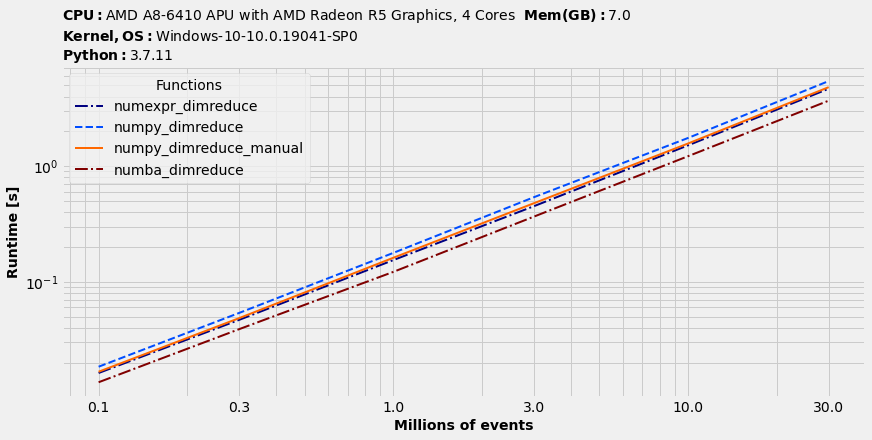

In [31]:
import benchit
%matplotlib inline
benchit.setparams(rep=3)

sizes = [100000, 300000, 1000000, 3000000, 10000000, 30000000]
N = sizes[-1]
events = np.random.uniform(low=(0, 0, 0, 0, 0, 229), high=(1000, 60, 60, 24, 7, 230), size=(N, 6)).astype(int)
arr = events[np.random.randint(N//3, size=N)]

def numexpr_dimreduce_int32(arr): return numexpr_dimreduce(arr, dtype=np.int32) #not safe

fns = [numexpr_dimreduce, numpy_dimreduce, numpy_dimreduce_manual, numba_dimreduce] 
       #numpy_unique_sort, numpy_unique_order, ckdtree_unique] #much slower ones

in_ = {s/1000000: (arr[:s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Millions of events')
t.plot(logx=True, figsize=(12, 6), fontsize=14)

**Further tests of `numexpr`**

Pastebėjome, kad `numexpr` nepadeda sutaupyti resursų palyginus su `numpy.dot`. Pabandykim pasižiūrėti, kiek įtakos skaičiavimo laikui turi mažiausio nario atiminėjimas iš kiekvieno nario:

In [36]:
def numexpr_dimreduce_min_calc(arr, dtype=np.int64):
    '''Calculates np.min and subtracts it'''
    arr = arr.astype(dtype=dtype)      
    names1, names2, names3 = zip(*((f'c{i}', f'M{i}', f's{i}') for i in range(arr.shape[1]))) 
    M = np.max(arr, axis=0)
    m = np.min(arr, axis=0)       
    limit = M - m + 1
    NAMESPACE1 = dict(zip(names1, arr.T))
    NAMESPACE2 = dict(zip(names2, np.cumprod(limit[:-1])))
    NAMESPACE3 = dict(zip(names3, m)) 
    EXPRESSION = '(c0-s0) + (c1-s1)*M0 + (c2-s2)*M1 + (c3-s3)*M2 + (c4-s4)*M3 + (c5-s5)*M4'
    return ne.evaluate(EXPRESSION, {**NAMESPACE1, **NAMESPACE2, **NAMESPACE3})
                                    
numexpr_dimreduce_that(X)

array([  78927348, 1451703955, 2704816575,  166704934, 1451703955,
       2704816575, 2704816575,  166704934,   78927348, 2704816575,
         78927348, 1451703955,  166704934, 2704816575, 1451703955],
      dtype=int64)

In [37]:
def numexpr_dimreduce_min_nocalc(arr, dtype=np.int64):
    arr = arr.astype(dtype=np.dtype)      
    names1, names2  = zip(*((f'c{i}', f'M{i}') for i in range(arr.shape[1]))) 
    M = np.max(arr, axis=0)
    m = np.min(arr, axis=0)  
    limit = M + 1
    NAMESPACE1 = dict(zip(names1, arr.T))
    NAMESPACE2 = dict(zip(names2, np.cumprod(limit[:-1])))
    EXPRESSION = 'c0 + c1*M0 + c2*M1 + c3*M2 + c4*M3 + c5*M4'
    return ne.evaluate(EXPRESSION, {**NAMESPACE1, **NAMESPACE2})
                                    
numexpr_dimreduce_this(X)

array([51127833450, 54390276735, 57397196239, 51329295410, 54390276735,
       57397196239, 57397196239, 51329295410, 51127833450, 57397196239,
       51127833450, 54390276735, 51329295410, 57397196239, 54390276735],
      dtype=int64)

In [38]:
def numexpr_dimreduce_no_min(arr, dtype=np.int64):
    arr = arr.astype(dtype=dtype)      
    names1, names2  = zip(*((f'c{i}', f'M{i}') for i in range(arr.shape[1]))) 
    M = np.max(arr, axis=0)     
    limit = M + 1
    NAMESPACE1 = dict(zip(names1, arr.T))
    NAMESPACE2 = dict(zip(names2, np.cumprod(limit[:-1])))
    EXPRESSION = 'c0 + c1*M0 + c2*M1 + c3*M2 + c4*M3 + c5*M4'
    return ne.evaluate(EXPRESSION, {**NAMESPACE1, **NAMESPACE2})
                                    
numexpr_dimreduce_this(X)

array([51127833450, 54390276735, 57397196239, 51329295410, 54390276735,
       57397196239, 57397196239, 51329295410, 51127833450, 57397196239,
       51127833450, 54390276735, 51329295410, 57397196239, 54390276735],
      dtype=int64)

In [44]:
#DEFINITELY A WINNER!
@njit
def _numba_dot(arr, dim_shapes, len_arr, len_dim_shapes, su):
    for i in range(len_arr):
        for j in range(len_dim_shapes):
            su[i] += arr[i][j] * dim_shapes[j]
        
def numba_dimreduce_no_calc(arr, dtype=np.int64):
    '''not safe if allocation is exceeded'''
    M = np.max(arr, axis=0)
    limit = np.array(M[:-1] + 1, dtype=dtype)
    dim_shapes = np.cumprod(np.insert(limit, 0, 1))
    su = np.zeros(len(arr), dtype=dtype)
    _numba_dot(arr, dim_shapes, len(arr), len(dim_shapes), su)
    return su

numba_dimreduce_no_calc(X)

array([51127833450, 54390276735, 57397196239, 51329295410, 54390276735,
       57397196239, 57397196239, 51329295410, 51127833450, 57397196239,
       51127833450, 54390276735, 51329295410, 57397196239, 54390276735],
      dtype=int64)

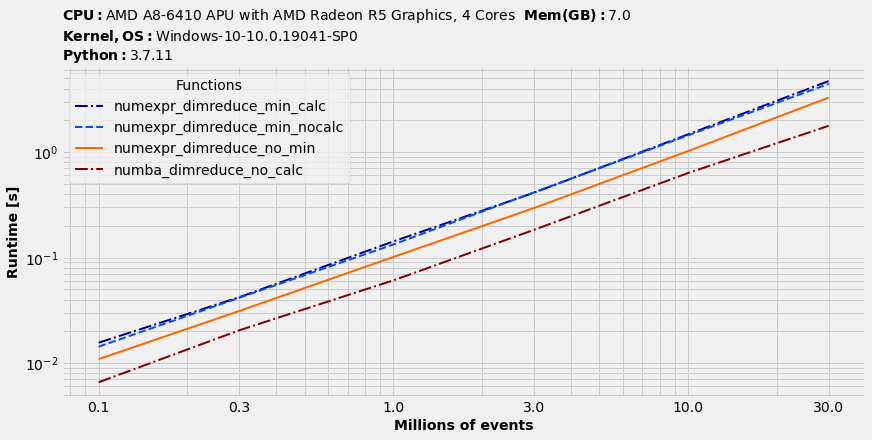

In [45]:
import benchit
%matplotlib inline
benchit.setparams(rep=3)

sizes = [100000, 300000, 1000000, 3000000, 10000000, 30000000]
N = sizes[-1]
events = np.random.uniform(low=(0, 0, 0, 0, 0, 229), high=(1000, 60, 60, 24, 7, 230), size=(N, 6)).astype(int)
arr = events[np.random.randint(N//3, size=N)]

fns = [numexpr_dimreduce_min_calc, numexpr_dimreduce_min_nocalc, numexpr_dimreduce_no_min, numba_dimreduce_no_calc]

in_ = {s/1000000: (arr[:s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Millions of events')
t.plot(logx=True, figsize=(12, 6), fontsize=14)

Išvada: mažiausio nario atiminėjimas laiko beveik neužima, bet jo radimas užima virš 30% algoritmo veikimo per `numexpr`. Bet `numba` - vis tiek nepavejamas.